In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
Path="/content/gdrive/MyDrive/NLP/tess/"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import os
from sklearn.model_selection import train_test_split
savee_directory_list = os.listdir(Path)

In [3]:
tess_directory_list = os.listdir(Path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Path + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Path + dir + '/' + file)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,/content/gdrive/MyDrive/NLP/tess/YAF_angry/YAF...
1,angry,/content/gdrive/MyDrive/NLP/tess/YAF_angry/YAF...
2,angry,/content/gdrive/MyDrive/NLP/tess/YAF_angry/YAF...
3,angry,/content/gdrive/MyDrive/NLP/tess/YAF_angry/YAF...
4,angry,/content/gdrive/MyDrive/NLP/tess/YAF_angry/YAF...


In [4]:
import librosa
from librosa.effects import time_stretch

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [5]:
sample_rate=22400
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
   # new_data = stretch(data)
    #data_stretch_pitch = pitch(data, sample_rate, pitch_factor=0.7)
    res3 = extract_features(data)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [7]:
X, Y = [], []
for path, emotion in zip(Tess_df.Path, Tess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [8]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.140530,0.513913,0.566778,0.510978,0.514117,0.440290,0.358072,0.361070,0.383467,0.479079,...,0.001701,0.001702,0.001341,0.000788,0.000698,0.000465,0.000343,0.000184,0.000020,angry
1,0.208055,0.608538,0.629435,0.614979,0.627910,0.538880,0.452614,0.443422,0.468669,0.611979,...,0.003919,0.003986,0.003601,0.003142,0.002917,0.002718,0.002624,0.002308,0.002192,angry
2,0.140530,0.513913,0.566778,0.510978,0.514117,0.440290,0.358072,0.361070,0.383467,0.479079,...,0.001701,0.001702,0.001341,0.000788,0.000698,0.000465,0.000343,0.000184,0.000020,angry
3,0.245705,0.566273,0.585020,0.552470,0.548187,0.487973,0.446994,0.506912,0.546774,0.545785,...,0.019686,0.020120,0.014171,0.004591,0.005646,0.005343,0.007719,0.005189,0.000715,angry
4,0.301147,0.616630,0.637064,0.638734,0.625819,0.561713,0.537335,0.582614,0.588213,0.599859,...,0.020237,0.020384,0.014837,0.005186,0.006472,0.005911,0.008250,0.005907,0.001242,angry


In [9]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [13]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

In [14]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import librosa
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [15]:
from keras.callbacks import ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
99/99 [==============================] - 47s 459ms/step - loss: 1.3476 - accuracy: 0.4884 - val_loss: 0.5617 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 45s 457ms/step - loss: 0.5407 - accuracy: 0.8137 - val_loss: 0.3105 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 42s 430ms/step - loss: 0.3273 - accuracy: 0.8956 - val_loss: 0.1750 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 49s 500ms/step - loss: 0.2283 - accuracy: 0.9310 - val_loss: 0.1313 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 42s 426ms/step - loss: 0.1577 - accuracy: 0.9498 - val_loss: 0.0795 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 45s 454ms/step - loss: 0.1624 - accuracy: 0.9462 - val_loss: 0.1803 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 47s 475ms/st

In [16]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

66/66 [==============================] - 3s 45ms/step - loss: 0.0099 - accuracy: 0.9957
Accuracy of our model on test data :  99.57143068313599 %


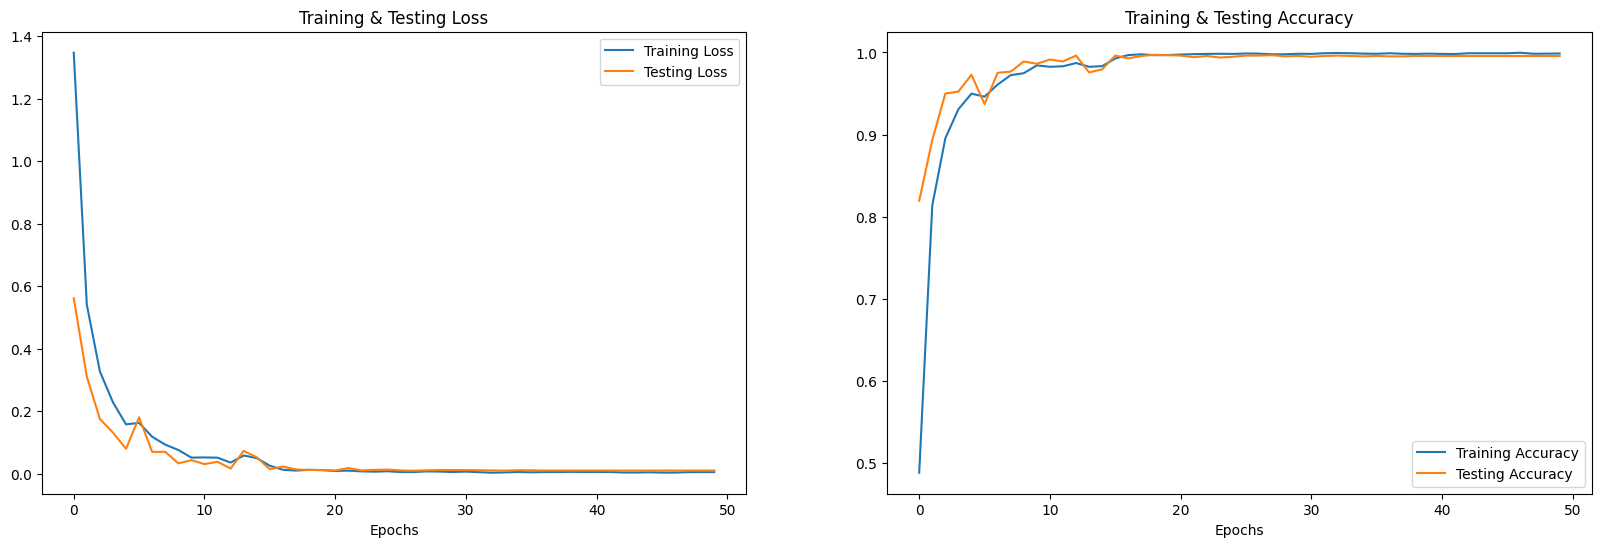

In [17]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [18]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 3s 44ms/step


In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,fear,fear
2,happy,happy
3,neutral,neutral
4,fear,fear
5,happy,happy
6,happy,happy
7,disgust,disgust
8,neutral,neutral
9,happy,happy


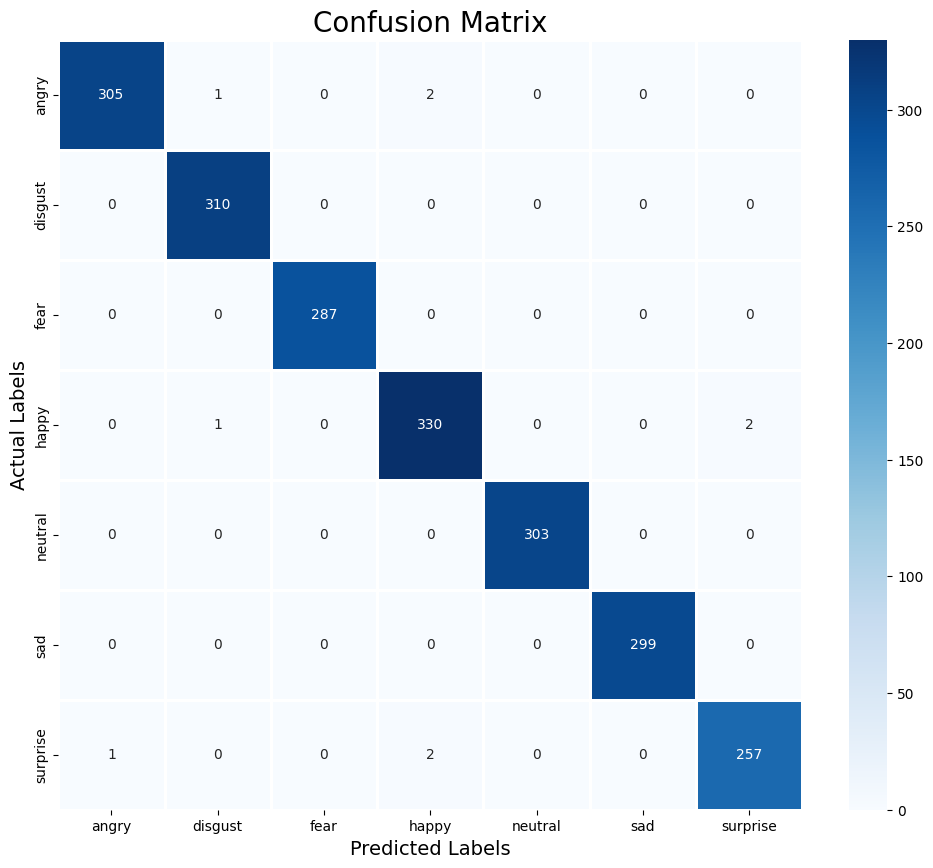

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       308
     disgust       0.99      1.00      1.00       310
        fear       1.00      1.00      1.00       287
       happy       0.99      0.99      0.99       333
     neutral       1.00      1.00      1.00       303
         sad       1.00      1.00      1.00       299
    surprise       0.99      0.99      0.99       260

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100

